<a href="https://colab.research.google.com/github/iris-kurapaty/CodingPractice/blob/main/Step4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
pwd

'/content'

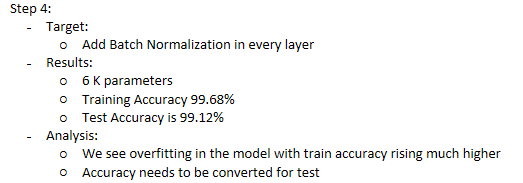

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
from model import *
from utils import *

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 535893780.06it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 110023336.81it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 195778949.66it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22869782.43it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


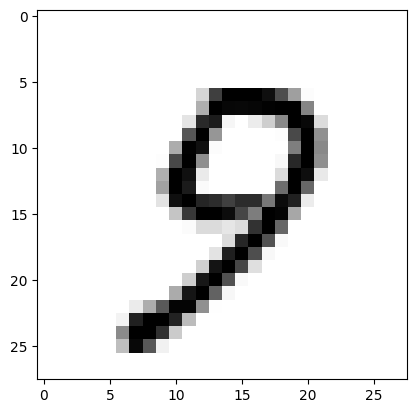

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_set = train_data.train_data
train_set = train_data.transform(train_set.numpy())

print('[Train]')
print(' - Numpy Shape:', train_data.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_data.train_data.size())
print(' - min:', torch.min(train_set))
print(' - max:', torch.max(train_set))
print(' - mean:', torch.mean(train_set))
print(' - std:', torch.std(train_set))
print(' - var:', torch.var(train_set))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


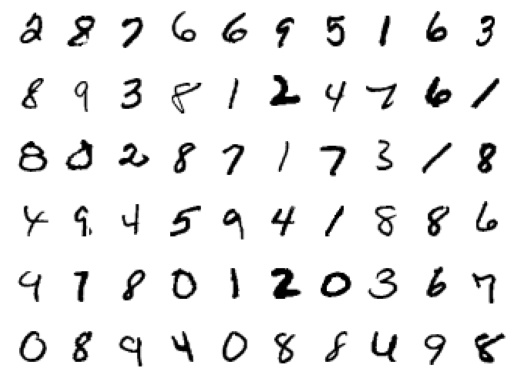

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

In [ ]:
from model import Net4

# Model Params

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_summary(Net4, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             576
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
         MaxPool2d-7            [-1, 8, 12, 12]               0
            Conv2d-8           [-1, 16, 12, 12]           1,152
       BatchNorm2d-9           [-1, 16, 12, 12]              32
             ReLU-10           [-1, 16, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]           1,152
      BatchNorm2d-12            [-1, 8, 10, 10]              16
             ReLU-13            [-1, 8, 10, 10]               0
        MaxPool2d-14              [-1, 

# Training and Testing


In [ ]:
train_losses_t = []
test_losses_t = []
train_acc_t = []
test_acc_t = []

# Let's Train and test our model

In [ ]:
model =  Net4().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses, train_acc = train(model, device, train_loader, optimizer, epoch)
    train_losses_t += train_losses
    train_acc_t.append(train_acc)
    test_losses, test_acc = test(model, device, test_loader)
    test_losses_t += test_losses
    test_acc_t.append(test_acc)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.027537299320101738 Batch_id=468 Accuracy=93.88: 100%|██████████| 469/469 [00:20<00:00, 23.39it/s]



Test set: Average loss: 0.0823, Accuracy: 9759/10000 (97.59%)

EPOCH: 1


Loss=0.06912880390882492 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:19<00:00, 23.56it/s]



Test set: Average loss: 0.0500, Accuracy: 9849/10000 (98.49%)

EPOCH: 2


Loss=0.016108063980937004 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:18<00:00, 24.79it/s]



Test set: Average loss: 0.0426, Accuracy: 9865/10000 (98.65%)

EPOCH: 3


Loss=0.04630788043141365 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:18<00:00, 25.62it/s]



Test set: Average loss: 0.0411, Accuracy: 9878/10000 (98.78%)

EPOCH: 4


Loss=0.07768744975328445 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]



Test set: Average loss: 0.0352, Accuracy: 9884/10000 (98.84%)

EPOCH: 5


Loss=0.043338924646377563 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:19<00:00, 24.47it/s]



Test set: Average loss: 0.0335, Accuracy: 9890/10000 (98.90%)

EPOCH: 6


Loss=0.17041049897670746 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:17<00:00, 26.22it/s]



Test set: Average loss: 0.0381, Accuracy: 9879/10000 (98.79%)

EPOCH: 7


Loss=0.022631825879216194 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:19<00:00, 24.47it/s]



Test set: Average loss: 0.0379, Accuracy: 9875/10000 (98.75%)

EPOCH: 8


Loss=0.046387042850255966 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:18<00:00, 26.05it/s]



Test set: Average loss: 0.0327, Accuracy: 9897/10000 (98.97%)

EPOCH: 9


Loss=0.009599984623491764 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:19<00:00, 24.43it/s]



Test set: Average loss: 0.0271, Accuracy: 9919/10000 (99.19%)

EPOCH: 10


Loss=0.003327958984300494 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:17<00:00, 26.27it/s]



Test set: Average loss: 0.0307, Accuracy: 9904/10000 (99.04%)

EPOCH: 11


Loss=0.016070066019892693 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:19<00:00, 24.43it/s]



Test set: Average loss: 0.0354, Accuracy: 9890/10000 (98.90%)

EPOCH: 12


Loss=0.0056428429670631886 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:19<00:00, 23.97it/s]



Test set: Average loss: 0.0325, Accuracy: 9906/10000 (99.06%)

EPOCH: 13


Loss=0.0045331744477152824 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:18<00:00, 24.78it/s]



Test set: Average loss: 0.0320, Accuracy: 9901/10000 (99.01%)

EPOCH: 14


Loss=0.013862121850252151 Batch_id=468 Accuracy=99.68: 100%|██████████| 469/469 [00:17<00:00, 26.35it/s]



Test set: Average loss: 0.0326, Accuracy: 9912/10000 (99.12%)



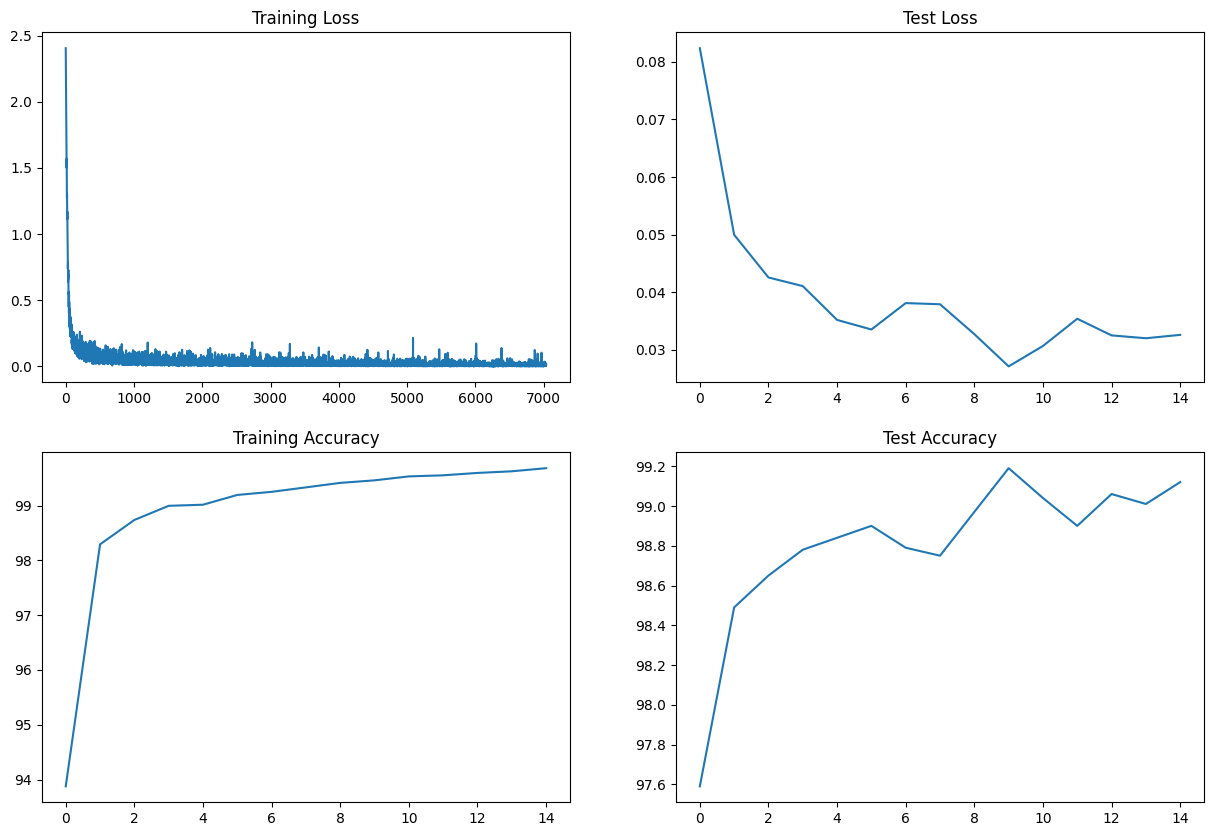

In [ ]:
plot_loss_acc(train_losses_t, train_acc_t, test_losses_t, test_acc_t)